# FLAME Testing
Test that the FLAME model works as expected.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import torch

if 'has_been_executed' not in locals():
    print("Changing directory to the root of the project")
    os.chdir("../../../")
    has_been_executed = True
else:
    print("The directory is correct")

Changing directory to the root of the project


In [2]:
from thesis.datasets import get_data_loader
from thesis.helpers import load_config

config = load_config("configs/config.yaml")
data_loader = get_data_loader(
    "nersemble",
    sequence=[3],
    time_step=55,
    batch_size=1,
    data_keys=["images", "camera", "flame_params"],
)
iterator = iter(data_loader)

ModuleNotFoundError: No module named 'thesis.datasets'

In [3]:
from thesis.external.flame import FlameHead

flame_head = FlameHead()
flame_head = flame_head.to("cuda")

In [4]:
from dreifus.render import project
from jaxtyping import Float, UInt8
from dreifus.matrix import Pose, Intrinsics
from beartype import beartype


@beartype
def draw(
    vertices: Float[torch.Tensor, "1 num_vertices 3"],
    image: Float[torch.Tensor, "1 H W 3"],  # type: ignore
    world_2_cam: Float[torch.Tensor, "1 4 4"],
    intrinsics: Float[torch.Tensor, "1 3 3"],
    overlay: bool = True,
) -> UInt8[np.ndarray, "H W 3"]:
    """
    Project the vertices to the image and draw them on the image.

    Args:
        vertices: The vertices to project.
        image: The image to draw on.
        world_2_cam: The world to camera transformation matrix.
        intrinsics: The camera intrinsics.

    Returns:
        The image with the vertices drawn on it.
    """
    vertices = vertices.squeeze(0).cpu().numpy()
    image = image.squeeze(0).cpu().numpy()
    world_2_cam = Pose(world_2_cam.squeeze(0).cpu().numpy())
    intrinsics = Intrinsics(intrinsics.squeeze(0).cpu().numpy())

    image = (image * 255).astype(np.uint8)
    projected = project(vertices, world_2_cam, intrinsics)
    projected_x = projected[:, 0].round().astype(int)
    projected_y = projected[:, 1].round().astype(int)
    valid_x = (0 <= projected_x) & (projected_x < image.shape[1])
    valid_y = (0 <= projected_y) & (projected_y < image.shape[0])
    valid_xy = valid_x & valid_y
    print(
        f"{valid_xy.sum() / projected.shape[0] * 100:.1f}% of the vertices are visible"
        f" i.e. {valid_xy.sum()} out of {projected.shape[0]}\n"
    )
    if not overlay:
        image = np.zeros_like(image)

    for y, x in zip(projected_y[valid_xy], projected_x[valid_xy]):
        for i in range(-2, 2):
            if not 0 <= y + i < image.shape[0]:
                continue
            for j in range(-2, 2):
                if not 0 <= x + j < image.shape[1]:
                    continue
                image[y + i, x + j] = [255, 255, 255]

    return image

100.0% of the vertices are visible i.e. 5143 out of 5143



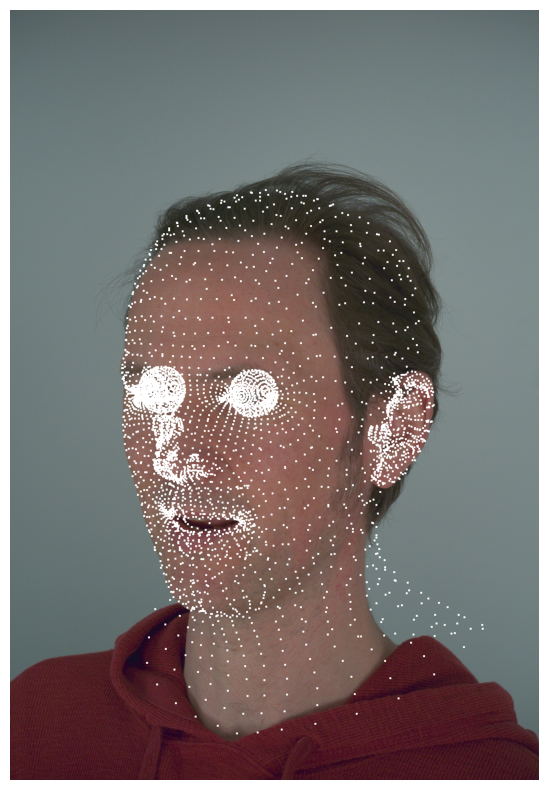

In [18]:
import matplotlib.pyplot as plt
from thesis.helpers import datum_to_device

try:
    batch = next(iterator)
except StopIteration:
    iterator = iter(data_loader)
    batch = next(iterator)

batch = datum_to_device(batch, "cuda")
flame_params = batch["flame_params"]
vertices = flame_head.forward(**flame_params, apply_se3_transform=True)
image = draw(
    vertices=vertices,
    image=batch["images"],
    world_2_cam=batch["camera"]["world_2_cam"],
    intrinsics=batch["camera"]["intrinsics"],
    overlay=True,
)

# Plot the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.show()

# cam 0 is a bit suspicious